In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import scipy.integrate as integrate


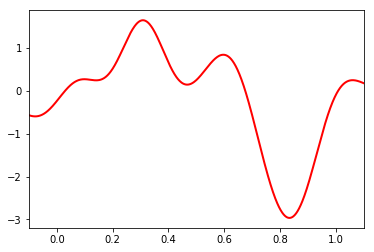

In [2]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=0.1)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
#     mean = gpy.mappings.Linear(dx, 1)
    mu = np.zeros(x.shape)
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    #import pdb; pdb.set_trace()
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.01

    def f(x): return m.predict(x)[0]
    return f
x_range = np.array([[0.], [1.]])
f = sample_function(x_range)

def plot_f(f):
    xx = np.linspace(-0.1, 1.1, 1000).reshape(1000, 1)
    yy = f(xx)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(-0.1, 1.1)
    plt.show()
plot_f(f)

def plot(m):
    xx = np.linspace(-5.0, 5.0, 300).reshape(300, 1)
    mean, std = m.predict(xx,return_std=True)
    mean = mean[:,0]
    plt.plot(xx, mean, 'r', lw=2)
    plt.fill_between(xx[:, 0],
                     mean - std**2,
                     mean + std**2,
                     color='r', alpha=0.2)
    plt.xlim(-5.0, 5.0)

[[-2.12078535e+00]
 [-7.03116488e+00]
 [-2.68383435e+00]
 [ 4.51371122e+00]
 [-8.72235937e+00]
 [-5.08496084e-01]
 [-1.25207882e-03]
 [-1.25210912e+00]
 [-2.46728646e+00]
 [ 1.35527210e+00]
 [ 5.41466224e+00]
 [ 1.37633326e+00]
 [-3.47184122e+00]
 [-4.34668793e+00]
 [-6.54957447e+00]
 [ 8.73574396e-02]
 [ 2.80854458e+00]
 [-1.76625484e+00]
 [ 4.22216389e+00]
 [-2.02410311e+00]]
[[-9.85829673e-099]
 [ 0.00000000e+000]
 [-1.11662752e-157]
 [-6.21743709e-269]
 [ 0.00000000e+000]
 [-3.83533064e-006]
 [-2.49992008e-001]
 [-8.55615599e-035]
 [-2.22538557e-133]
 [-1.34446380e-003]
 [ 0.00000000e+000]
 [-6.84441940e-004]
 [-2.73853406e-263]
 [ 0.00000000e+000]
 [ 0.00000000e+000]
 [ 2.61559949e-001]
 [-1.22976659e-071]
 [-1.11466920e-068]
 [-2.99593722e-226]
 [-5.37959721e-090]]


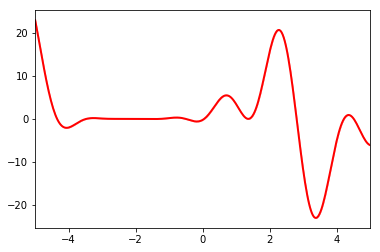

In [11]:
# k = GPy.kern.src.rbf.RBF(input_dim=1,lengthscale=0.1)
kernel = RBF(1.0, (1e-2, 1e2))
x = np.random.normal(0,4,(20,1))
y = f(x)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,optimizer=None)
gp.fit(x,y)
plot(gp)
print x
print y


In [12]:
u,v = gp.predict(0.3,return_std=True)
print u, v**2

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kernel_(np.array([[x]]),gp.X_train_)
        return np.dot(Kxpx,gp.alpha_)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxx = gp.kernel_(np.array([[x]]),np.array([[y]]))
        Kxxx = gp.kernel_(np.array([[x]]),gp.X_train_)
        Kyxx = gp.kernel_(gp.X_train_,np.array([[y]]))
        return Kxx - Kxxx*gp.kernel_(gp.X_train_,gp.X_train_)*Kyxx
    return lambda x,y: f(x,y)

cov1 = lambda x,y: gp.kernel_(np.array([[x]]),np.array([[y]]))
cov2 = (lambda x,y: gp.kernel_(np.array([x]),gp.X_train_).dot(cho_solve((gp.L_, True), gp.kernel_(gp.X_train_,np.array([[y]])))))
# x = 0.3
# print gp.kernel_(np.array([[x]]),np.array([[0.0]]))

# def test_cov(gp):
#     def f(x):
#         print x
#         gp.kernel_(np.array([[x]]),np.array([[0.0]]))*gp.kernel_(gp.X_train_,gp.X_train_)*gp.kernel_(np.array([[0.0]]),np.array([[y]]))*normal(x)*normal(y)
#     return f
print get_mean_func(gp)(0.3)
# print get_cov_func(gp)(0.3,0.0)
print cov1(0.3,0.3) - cov2(0.3,0.3)
# print gp.kernel_(np.array([0.3]),gp.X_train_)

# print ((1.0**2 +2.0**2)/(1.0**2))**(-0.5)
# print 0.4472135954999581 * gp.alpha_

[[2.28835485]] [1.71545793e-07]
[[2.28835485]]
[[1.71111034e-07]]


In [ ]:
## def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(5.0)).pdf(s)

print "Mean Numerical Integration"
print integrate.quad(lambda x: gp.predict(x,return_std=True)[0][0]*normal(x),np.NINF,np.inf)
# print integrate.quad(lambda x: gp.kernel_(np.array([[x]]),np.array([[0.0]]))*normal(x),np.NINF,np.inf)
# print "Var Numerical Integration"
# print integrate.quad(lambda x: gp.predict(x,return_std=True)[1][0]*normal(x),np.NINF,np.inf)
# print "other"
# print integrate.quad(lambda x: gp.kernel_(np.array([[x]]),np.array([[0.0]]))*normal(x),np.NINF,np.inf)
c1 = integrate.dblquad(lambda x,y: cov1(x,y)*normal(x)*normal(y),-5.0,5.0, lambda x: -5.0, lambda x: 5.0)
c2 = integrate.dblquad(lambda x,y: cov2(x,y)*normal(x)*normal(y),-5.0,5.0, lambda x: -5.0, lambda x: 5.0)
print c1,c2
print c1[0] - c2[0]
# print integrate.dblquad(lambda x,y: get_cov_func(gp)(x,y)*normal(x)*normal(y),-5.0,5.0, lambda x: -5.0, lambda x: 5.0)

# Mean Numerical Integration
# (0.09950371901104851, 8.07137139656537e-09)
# Var Numerical Integration
# (0.9499497153837378, 1.0189813132515364e-08)
# other
# (0.9645737664686658, 1.4874928277555785e-08)


In [6]:
b = np.array([0.0])
B = np.array([[5.0]])
def bintegrate(gp,b,B):
    n,dim = gp.X_train_.shape
    length_scale = gp.kernel_.length_scale
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X_train_
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = (z.T).dot(cho_solve((gp.L_, True), gp.y_train_))
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
#     print var_determ
#     print np.dot(z.T, cho_solve((gp.L_, True), z))
    var = var_determ - np.dot(z.T, cho_solve((gp.L_, True), z))
    return mean[0][0], var[0][0]
bintegrate(gp,b,B)

(-0.1753841806543342, 0.1089290322580842)

401.00000000000006

In [80]:
a = gpy.mappings.Linear(dx, 1)

In [327]:
gp.kernel_(gp.X_train_,gp.X_train_)

array([[1.]])